## Starting with Michael Wood-Vasey's notebook as a starting point
## Craig Lage - 29Aug18

## Make a brighter-fatter kernel from a set of high-intensity flats measured at UC Davis.
## Run correlations by amplifier. Testing storing correlation data

In [2]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib


lsst_distrib          16.0+3     	current w_2018_26 setup


In [3]:
import numpy as np
import matplotlib.pyplot as plt
# if running stack v16.0, silence a long matplotlib Agg warning with:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
# Test to make sure that we can import obs_lsstCam
import lsst.obs.base
import lsst.obs.lsstCam

In [5]:
from lsst.cp.pipe.makeBrighterFatterKernel import MakeBrighterFatterKernelTask
from lsst.daf.persistence import Butler
from lsst.pipe.tasks.ingest import IngestTask

In [6]:
!pwd

/sandbox/cslage/Research/LSST/code/notebooks/DC2_Notebooks


## Ingest 5 pairs of flats from UC Davis measurements

In [7]:
!ls /mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_100_20180514??????.fits

/mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_100_20180514141655.fits


In [8]:
# Don't need to run this each time
!rm -rf ucd_repo
! mkdir ucd_repo
! echo "lsst.obs.lsstCam.LsstCamMapper" > ucd_repo/_mapper

# Ingest the  flats. The ?00 and ?01 are the flat pairs
! ingestImages.py ucd_repo /mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_?00_20180514??????.fits --mode link
! ingestImages.py ucd_repo /mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_?01_20180514??????.fits --mode link

root INFO: Loading config overrride file '/sandbox/cslage/Research/LSST/code/w_2018_26/obs_lsstCam/config/ingest.py'
LsstCamMapper WARN: Unable to find calib root directory
CameraMapper INFO: Loading Posix exposure registry from /sandbox/cslage/Research/LSST/code/notebooks/DC2_Notebooks/ucd_repo
ingest INFO: /mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_100_20180514141655.fits --<link>--> /sandbox/cslage/Research/LSST/code/notebooks/DC2_Notebooks/ucd_repo/raw/100/R21/00000100-R21-S11-det085-000.fits
ingest INFO: /mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_200_20180514143548.fits --<link>--> /sandbox/cslage/Research/LSST/code/notebooks/DC2_Notebooks/ucd_repo/raw/200/R21/00000200-R21-S11-det085-000.fits
ingest INFO: /mnt/storm-lsst/GUI/20180514_002_flats_3/ITL-3800C-002_flat_flat_300_20180514145807.fits --<link>--> /sandbox/cslage/Research/LSST/code/notebooks/DC2_Notebooks/ucd_repo/raw/300/R21/00000300-R21-S11-det085-000.fits
ingest INFO: /mnt/stor

In [9]:
butler = Butler('ucd_repo')


So I got this far, and it has successfully ingested the images.  So far, all I have done is:

     (1) Copied MWV code and hacks as closely as I could.
         (A) Using w_2018_26
         (B) obs_base tickets/DM-13293
         (C) obs_lsstCam tickets/DM-15509
         (D) cp_pipe tickets/DM-13293
         (E) Comment out the `exposure.setWcs` command in the raw assembly in `obs_lsstCam`.
         (F) Define a wrapper `run` method in `makeBrighterFatterTask.py` that calls `runDataRef`.
         (G) Comment out from .cpTask import * in the `cp_pipe/python/lsst/cp/pipe/__init__.py` file.

     (2) edit obs_lsstCam/config/ingest.py to use some different header values
     (3) edit obs_lsstCam/python/lsst/obs/lsstCam/ingest.py to work with these different values and 
     to fudge the raft and sensor IDs.


In [10]:
print(butler.queryMetadata('src', ['visit', 'detector', 'filter', 'id', 'raftName', 'detectorName']))
# Note that the 'detector' value is 85, and I have hacked the CCD to be R21:S11

[(100, 85, 'r', 1, 'R21', 'S11'), (200, 85, 'r', 2, 'R21', 'S11'), (300, 85, 'r', 3, 'R21', 'S11'), (400, 85, 'r', 4, 'R21', 'S11'), (500, 85, 'r', 5, 'R21', 'S11'), (101, 85, 'r', 6, 'R21', 'S11'), (201, 85, 'r', 7, 'R21', 'S11'), (301, 85, 'r', 8, 'R21', 'S11'), (401, 85, 'r', 9, 'R21', 'S11'), (501, 85, 'r', 10, 'R21', 'S11')]


In [11]:
# Put in the approximate measured gain values
amp_names = ['C{:02d}'.format(i) for i in range(18)]
ucd_gain = 4.5
nominalGain = {a: ucd_gain for a in amp_names}
gain = nominalGain
dataRef = butler.dataRef('brighterFatterGain', dataId={'detector': 85}) 
dataRef.put(gain, 'brighterFatterGain')

Now try calculating the brighter-fatter kernel using `MakeBrighterFatterKernelTask`. By setting level='AMP', we force amplifier by amplifier calculations. This first attempt is with assumed gains.

Now repeating it with calculated gains.  I needed to make some edits to prevent it from exiting on the bad amps.
I also am attempting to store the measured correlations.

In [12]:
args = ['ucd_repo', '--rerun', 'test',
        '--id', 'detector=85',
        '--visit-pairs', '100,101', '200,201', '300,301', '400,401', '500,501',
        '-c',
        'xcorrCheckRejectLevel=2', 'doCalcGains=True', 'level="AMP"',
        '--clobber-config', '--clobber-versions'
       ]

command_line = 'makeBrighterFatterKernel.py ' + ' '.join(args)
print(command_line)

ucd_pb_struct = MakeBrighterFatterKernelTask.parseAndRun(args=args)

makeBrighterFatterKernel.py ucd_repo --rerun test --id detector=85 --visit-pairs 100,101 200,201 300,301 400,401 500,501 -c xcorrCheckRejectLevel=2 doCalcGains=True level="AMP" --clobber-config --clobber-versions


In [13]:

ucd_detector = 85
test_butler = Butler('ucd_repo/rerun/test')
ucd_bf_kernel = test_butler.get('brighterFatterKernelNew', dataId={'raftName': 'R21', 'detectorName': 'S11', 'detector': ucd_detector})

In [14]:
#It now runs with doCalcGains=True
ucd_detector = 85
test_butler = Butler('ucd_repo/rerun/test')
ucd_bf_kernel = test_butler.get('brighterFatterKernelNew', dataId={'raftName': 'R21', 'detectorName': 'S11', 'detector': ucd_detector})
gain_data = test_butler.get('brighterFatterGain', dataId={'raftName': 'R21', 'detectorName': 'S11', 'detector': 85})

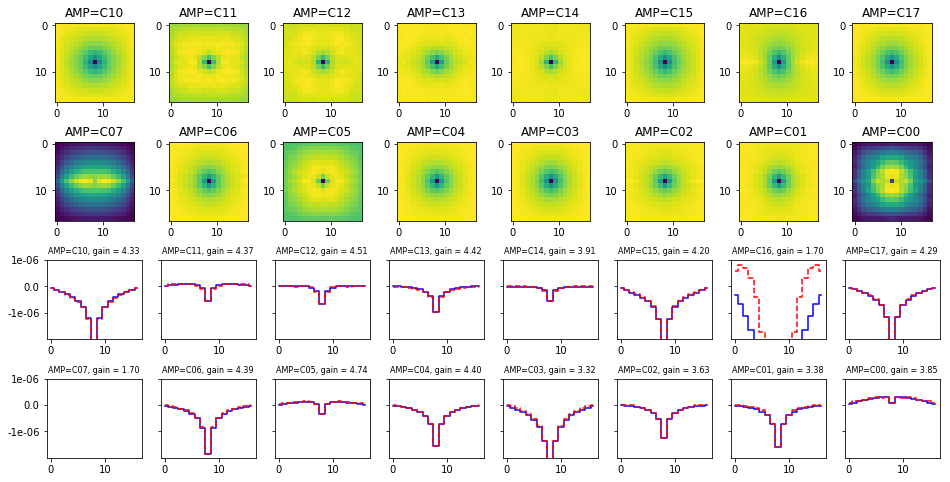

In [15]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(hspace=0.5)
for i, key in enumerate(ucd_bf_kernel.keys()):
    plt.subplot(4,8,i+1)
    plt.title('AMP=%s'%key) 
    plt.imshow(ucd_bf_kernel[key])
    ax1 = plt.subplot(4,8,i+17)
    ax1.set_title('AMP=%s, gain = %.2f'%(key,gain_data[key]),fontsize = 8) 
    ax1.set_ylim(-2.0E-6,1.0E-6)
    ax1.set_yticks([-1.0E-6, 0.0,1.0E-6])
    ax1.plot(ucd_bf_kernel[key][:,8], color='blue', drawstyle='steps-mid')
    ax1.plot(ucd_bf_kernel[key][8,:], linestyle='--', color='red', drawstyle='steps-mid')

    if (i == 0 or i == 8):
        ax1.set_yticklabels([-1.0E-6, 0.0,1.0E-6])
    else:
        ax1.set_yticklabels([])
        

plt.savefig('BF_Kernel_29Aug18.pdf')
plt.show()